
## Arquitectura de la Aplicación Científica de Trading con IA (Fase 1: Usuario Único)

Esta aplicación está diseñada para un trader profesional que quiere entender su rendimiento desde una perspectiva científica, psicológica y estadística, con posibilidad de integración futura con agentes de IA.

### Flujo General del Sistema

1. **Entrada automática del archivo**: el trader deja un archivo Excel en la carpeta `input/`.
2. **Procesamiento incremental**: sólo se procesan los archivos nuevos gracias a la columna `source_file` en el histórico.
3. **Extracción de hojas clave**: `Journal`, `Executions`, `Statistics`.
4. **Construcción del `hist_df`**: dataset enriquecido con datos operativos y metainformación.
5. **Cálculo de métricas psicológicas**: tiempo en ganadores vs perdedores, reactividad tras pérdidas, entre otras.
6. **Exportación**: tanto en CSV como en PostgreSQL para trazabilidad y consultas avanzadas.

### Carga de Archivos: Modo Manual vs Automático

Esta celda permite trabajar en dos modos:

- **Modo Manual**: útil durante pruebas, permite seleccionar un archivo concreto.
- **Modo Automático**: producción. Toma automáticamente el archivo más reciente desde la carpeta `input/`.

Estructura esperada:
```bash
📁 proyecto_trading/
├── 📁 input/
│   └── ATAS_statistics_YYYYMMDD.xlsx
├── 00.ipynb
```

> Se procesa sólo el archivo nuevo, evitando reprocesamientos.

### Construcción del DataFrame Central (`hist_df`)

Se construye a partir de las 3 hojas del archivo Excel:

- `Journal`: núcleo del trade (entrada, salida, PnL...)
- `Executions`: IDs de órdenes y comisiones.
- `Statistics`: resumen agregado diario (guardado como `daily_stats`).

#### Enriquecimientos:
- `source_file`: trazabilidad del origen.
- `commission`, `PnL_net`: cálculo neto del beneficio.
- `notes`, `emotion`, `situation`: campos para anotaciones subjetivas.
- `comment`: columna original del trader en ATAS.
- `duration_minutes`: tiempo de permanencia en el trade.

Esto permite análisis científico y psicológico del comportamiento operativo.

### Análisis Psicológico y Métricas Derivadas

Funciones integradas para explorar el comportamiento emocional del trader:

- Comparación de duración entre trades ganadores vs perdedores.
- Identificación de aumento de riesgo tras pérdidas significativas.
- Preparado para alimentar agentes conversacionales.

> Ejemplo: "Hoy operaste el doble tras una gran pérdida. ¿Fue impulsivo o parte de tu estrategia?"

### Estrategia de Almacenamiento: CSV + PostgreSQL

#### Opción A — CSVs acumulativos
- `trades_hist.csv`: todos los trades diarios.
- `trading_summary.csv`: resumen por día.

**Ventajas**:
- Simples, auditables, reproducibles.
- Ideal para prototipos y notebooks interactivos.

#### Opción B — PostgreSQL
- Eficiente, consultable por filtros.
- Escalable a producción multiusuario.

#### Enfoque Adoptado
> Empezamos con CSVs para desarrollo rápido.
> Paralelamente, guardamos en PostgreSQL (`trades`, `daily_summary`) para análisis y futura conexión con IA.

Esto proporciona flexibilidad para crecer hacia una arquitectura más avanzada sin reescribir el núcleo del sistema.




In [461]:
# ────────────────────────────────────────────────────
#  ATAS FIFO Loader — v2.3.4  (🗓️ 2025‑06‑14)
#  • Reconstruye trades FIFO desde «Executions».
#  • Corrige PnL con multiplier por contrato (MES $5, MNQ $2…).
#  • `merge_split_trades()` agrupa fills del mismo trade visual y crea:
#       - `components`  : lista con los trade_id FIFO fusionados
#       - `n_components`: nº de fills del trade visual
#       - `is_fragmented`: booleano (trade parcial sí/no)
#  • `process_new_files(merge_fragments=True)` aplica todo en un paso.
#  • Helpers:
#       - `daily_summary_from_hist()`   → resumen diario + trades fragmentados
#       - `get_fragmented_trade_ids_by_day()` → ids fragmentados por día
#       - `explain_fragmented_trade()`  → desglose textual paso a paso
#       - `build_bayesian_params()`     → parámetros para simulación bayesiana
#       - `simulate_equity()`           → simulaciones Monte Carlo de equity
#  • En la fila TOTAL de `daily_summary_from_hist()` se incluyen todos los `fragmented_ids` acumulados.
# ────────────────────────────────────────────────────

# 📦 CELL 1: Imports and Config
# ────────────────────────────────────────────
import os
from pathlib import Path
import pandas as pd
from sqlalchemy import create_engine, text
import logging
from dotenv import load_dotenv
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt

load_dotenv()

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
logger = logging.getLogger(__name__)

DATABASE_URL    = os.getenv("DATABASE_URL", "postgresql+psycopg2://alex@localhost:5432/trading")
INPUT_DIR       = Path("../input")
OUTPUT_DIR      = Path("../output")
HIST_PATH       = OUTPUT_DIR / "trades_hist.csv"
INITIAL_CAPITAL = 419 # has restado la primera semana que fue con la estrategia mala

CONTRACT_MULTIPLIER = {
    "MES": 5,
    "MNQ": 2,
}

INPUT_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

# 📦 CELL 2: Reset Helpers
# ────────────────────────────────────────────

def reset_local_csv():
    """Elimina el CSV acumulado local."""
    if HIST_PATH.exists():
        HIST_PATH.unlink()
        logger.info("🗑️  trades_hist.csv eliminado.")

def reset_database():
    """Borra la tabla PostgreSQL 'trades'."""
    engine = create_engine(DATABASE_URL)
    with engine.begin() as conn:
        conn.execute(text("DROP TABLE IF EXISTS trades"))
    logger.info("🧹  Tabla 'trades' eliminada en PostgreSQL.")

# 📦 CELL 3: State Helpers
# ────────────────────────────────────────────

def check_database_status(msg=""):
    """Imprime cuántos registros hay en la tabla 'trades'."""
    engine = create_engine(DATABASE_URL)
    with engine.connect() as conn:
        exists = conn.execute(text("SELECT EXISTS (SELECT FROM information_schema.tables WHERE table_name = 'trades')")).scalar()
        count  = conn.execute(text("SELECT COUNT(*) FROM trades")).scalar() if exists else 0
    logger.info(f"📊 {msg}DB contiene {count} trades.")

# 📦 CELL 4: Persistence
# ────────────────────────────────────────────

def load_accumulated_data():
    """Carga el CSV acumulado si existe."""
    if HIST_PATH.exists():
        df = pd.read_csv(HIST_PATH, parse_dates=["entry_time", "exit_time"], low_memory=False)
    else:
        df = pd.DataFrame()
    if "source_file" not in df.columns:
        df["source_file"] = ""
    return df


def save_to_csv(hist_df: pd.DataFrame):
    """Guarda el historial a CSV evitando duplicados."""
    if "trade_id" in hist_df.columns:
        hist_df.drop_duplicates(subset=["trade_id"], inplace=True)
    if {"order_id_entry", "order_id_exit"}.issubset(hist_df.columns):
        hist_df.drop_duplicates(subset=["order_id_entry", "order_id_exit"], inplace=True)
    hist_df.to_csv(HIST_PATH, index=False)


def save_to_postgres(hist_df: pd.DataFrame):
    """Sustituye la tabla 'trades' en PostgreSQL por el nuevo DataFrame."""
    engine = create_engine(DATABASE_URL)
    hist_df.to_sql("trades", engine, if_exists="replace", index=False)
    logger.info("💾  Datos guardados en PostgreSQL (trades).")

# 📦 CELL 5: Leer Excel
# ────────────────────────────────────────────

def load_excel_file(filepath: Path):
    """Carga la pestaña 'Executions' de un fichero ATAS."""
    try:
        xls = pd.ExcelFile(filepath)
        if "Executions" not in xls.sheet_names:
            logger.warning(f"{filepath.name} sin pestaña Executions → omitido.")
            return None
        return pd.read_excel(xls, sheet_name="Executions")
    except Exception as e:
        logger.error(f"Error leyendo {filepath.name}: {e}")
        return None

# 📦 CELL 6: FIFO Reconstruction
# ────────────────────────────────────────────

def _get_multiplier(symbol: str):
    root = "".join([c for c in symbol.upper() if c.isalpha()])
    return CONTRACT_MULTIPLIER.get(root[:3], 1)


def reconstruct_trades_from_executions(exe: pd.DataFrame, source_file: str):
    """Reconstruye trades FIFO a partir de los fills de ATAS."""
    exe = exe.copy()
    exe["Direction"] = exe["Direction"].astype(str).str.strip().str.lower()
    exe["Time"]      = pd.to_datetime(exe["Time"])
    exe.sort_values("Time", inplace=True)

    queues: dict = {}
    trades       = []
    trade_id     = 1

    for _, row in exe.iterrows():
        key = (row["Account"], row["Instrument"])
        queues.setdefault(key, [])

        dir_    = row["Direction"]
        volume  = row["Volume"]
        price   = row["Price"]
        fill = {
            "time":        row["Time"],
            "price":       price,
            "volume":      volume,
            "direction":   dir_,
            "exchange_id": row["Exchange ID"],
            "commission":  row.get("Commission", 0),
        }

        q = queues[key]
        if not q or q[-1]["direction"] == dir_:
            q.append(fill)
            continue

        while volume > 0 and q:
            open_fill = q[0]
            delta     = min(volume, open_fill["volume"])
            volume   -= delta
            open_fill["volume"] -= delta

            entry_price = open_fill["price"]
            exit_price  = price
            multiplier  = _get_multiplier(row["Instrument"])
            pnl_point   = (exit_price - entry_price) if open_fill["direction"] == "buy" else (entry_price - exit_price)
            pnl_dollars = pnl_point * delta * multiplier

            trades.append({
                "trade_id":        trade_id,
                "entry_time":      open_fill["time"],
                "exit_time":       fill["time"],
                "asset":           row["Instrument"],
                "entry_price":     entry_price,
                "exit_price":      exit_price,
                "position_size":   delta,
                "PnL":             pnl_dollars,
                "PnL_net":         pnl_dollars - (open_fill["commission"] + fill.get("Commission", 0)),
                "commission":      open_fill["commission"] + fill.get("Commission", 0),
                "account":         row["Account"],
                "exchange":        "CME",
                "direction":       "Buy" if open_fill["direction"] == "buy" else "Sell",
                "order_id_entry":  open_fill["exchange_id"],
                "order_id_exit":   fill["exchange_id"],
                "source_file":     source_file,
            })
            trade_id += 1

            if open_fill["volume"] == 0:
                q.pop(0)

        if volume > 0:
            fill["volume"] = volume
            q.append(fill)

    df = pd.DataFrame(trades)
    if df.empty:
        return df

    df["duration_minutes"] = (pd.to_datetime(df["exit_time"]) - pd.to_datetime(df["entry_time"]))\
                                .dt.total_seconds() / 60
    df["equity"] = INITIAL_CAPITAL + df["PnL_net"].cumsum()
    return df

# 📦 CELL 7: Merge split trades
# ────────────────────────────────────────────
def merge_split_trades(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df

    df = df.copy()
    df["components"] = df["trade_id"].apply(lambda x: [x])

    group_cols = ["entry_time", "exit_time", "asset", "direction"]
    agg = {
        "entry_price": "first",
        "exit_price": "first",
        "position_size": "sum",
        "PnL": "sum",
        "PnL_net": "sum",
        "commission": "sum",
        "order_id_entry": "first",
        "order_id_exit": "first",
        "account": "first",
        "exchange": "first",
        "source_file": "first",
        "components": lambda x: sum(x, []),
    }

    merged = df.groupby(group_cols, as_index=False).agg(agg)
    merged["duration_minutes"] = (pd.to_datetime(merged["exit_time"]) - pd.to_datetime(merged["entry_time"]))\
                                    .dt.total_seconds() / 60
    merged["trade_id"] = range(1, len(merged) + 1)
    merged["equity"] = INITIAL_CAPITAL + merged["PnL_net"].cumsum()
    merged["n_components"] = merged["components"].apply(len)
    merged["is_fragmented"] = merged["n_components"] > 1
    return merged

# 📦 CELL 8: Daily Summary
# ─────────────────────────────────────
def daily_summary_from_hist(hist_df: pd.DataFrame):
    if hist_df.empty:
        return pd.DataFrame()

    df = hist_df.copy()
    if "is_fragmented" not in df.columns:
        df["is_fragmented"] = df["components"].apply(lambda c: len(c) > 1)
    df["day"] = pd.to_datetime(df["exit_time"]).dt.date

    summary = (
        df.groupby("day")
          .agg(total_trades       = ("trade_id", "nunique"),
               net_pnl            = ("PnL_net",  "sum"),
               win_rate           = ("PnL_net",  lambda x: (x > 0).mean()),
               fragmented_trades  = ("is_fragmented", "sum"))
          .reset_index()
    )

    fragments = (df[df["is_fragmented"]]
                 .groupby("day")["trade_id"]
                 .apply(list)
                 .reset_index(name="fragmented_ids"))

    summary = pd.merge(summary, fragments, on="day", how="left")
    summary["fragmented_ids"] = summary["fragmented_ids"].apply(
                                    lambda x: x if isinstance(x, list) else [])

    from itertools import chain
    total_gain = df[df["PnL_net"] > 0]["PnL_net"].sum()
    total_loss = df[df["PnL_net"] < 0]["PnL_net"].abs().sum()
    profit_factor = total_gain / total_loss if total_loss != 0 else np.nan

    totals_row = {
        "day"              : "TOTAL",
        "total_trades"     : summary["total_trades"].sum(),
        "net_pnl"          : summary["net_pnl"].sum(),
        "win_rate"         : (df["PnL_net"] > 0).mean(),
        "fragmented_trades": summary["fragmented_trades"].sum(),
        "fragmented_ids"   : list(chain.from_iterable(
                                        x if isinstance(x, list) else [] for x in summary["fragmented_ids"]
                                     )),
        "profit_factor"    : profit_factor,
    }
    summary = pd.concat([summary, pd.DataFrame([totals_row])], ignore_index=True)

    global total_trades_all, total_net_pnl, total_win_rate, total_fragmented, profit_factor_global
    total_trades_all = totals_row["total_trades"]
    total_net_pnl    = totals_row["net_pnl"]
    total_win_rate   = totals_row["win_rate"]
    total_fragmented = totals_row["fragmented_trades"]
    profit_factor_global = profit_factor


    return summary


# 📦 CELL 9: Explicación estructurada de un trade fragmentado
# ─────────────────────────────────────
def explain_fragmented_trade(hist_df: pd.DataFrame, full_df: pd.DataFrame, trade_id: int) -> list:
    row = hist_df.loc[hist_df.trade_id == trade_id]
    if row.empty:
        return [f"Trade {trade_id} no encontrado."]
    row = row.squeeze()

    comps = row["components"]
    if len(comps) <= 1:
        return [f"Trade {trade_id} no está fragmentado."]

    steps = [f"🎯 Trade {trade_id} ({row['direction']}, {row['position_size']} contratos, {row['asset']})",
             "→ Composición:"]
    for tid in comps:
        frag = full_df.loc[full_df.trade_id == tid].squeeze()
        steps.append(f"• {frag['entry_time'].strftime('%H:%M:%S')} {frag['direction']} "
                     f"{frag['position_size']} @ {frag['entry_price']} → {frag['exit_price']} "
                     f"({frag['PnL_net']:.2f}$)")
    return steps

**Carga dos DataFrames en el orden correcto**

In [462]:
# 1. Procesar sin merge
full_df = process_new_files(reprocess_existing=True, merge_fragments=False)

# 2. Añadir componentes manualmente
full_df["components"] = full_df["trade_id"].apply(lambda x: [x])

# 3. Hacer merge correctamente
hist_df = merge_split_trades(full_df)

# 4. Generar resumen con totales
summary = daily_summary_from_hist(hist_df)

# 5. Mostrar
summary



INFO: 📊 Antes de cargar → DB contiene 62 trades.
INFO: ✅ Añadidos 62 trades desde ATAS_statistics_08062025_30062025.xlsx.
INFO: 💾  Datos guardados en PostgreSQL (trades).
INFO: 📊 Después de cargar → DB contiene 62 trades.


,day,total_trades,net_pnl,win_rate,fragmented_trades,fragmented_ids,profit_factor
0,2025-06-09,11,-81.00,0.545455,3,"[2, 4, 5]",NaN
1,2025-06-10,9,204.50,0.555556,1,[13],NaN
2,2025-06-11,12,100.75,0.666667,0,[],NaN
3,2025-06-12,11,-144.50,0.272727,1,[36],NaN
4,2025-06-13,10,146.50,0.600000,0,[],NaN
5,TOTAL,53,226.25,0.528302,5,"[2, 4, 5, 13, 36]",1.372275


**Consultamos los trades fragmentados por día `fragment_ids` son lis id´s de los trades donde se fragmento la operacion**

In [463]:
print(f"🔢 Total de trades ejecutados: {total_trades_all}")
print(f"💰 PnL neto acumulado: {total_net_pnl:.2f} USD")
print(f"📈 Win Rate global: {total_win_rate:.2%}")
print(f"🧩 Número de trades fragmentados: {total_fragmented}")
print(f"📈 Profit Factor global: {profit_factor_global:.2f}")



🔢 Total de trades ejecutados: 53
💰 PnL neto acumulado: 226.25 USD
📈 Win Rate global: 52.83%
🧩 Número de trades fragmentados: 5
📈 Profit Factor global: 1.37


In [464]:
# Ejemplo para un día concreto
ids_dia = summary.loc[summary.day == pd.to_datetime("2025-06-09").date(), "fragmented_ids"].iat[0]

for tid in ids_dia:                     # recorre cada trade-id fragmentado
    for line in explain_fragmented_trade(hist_df, full_df, trade_id=tid):
        print(line)
    print()  


🎯 Trade 2 (Buy, 4.0 contratos, MNQM5@CME)
→ Composición:
• 09:43:43 Buy 3.0 @ 21791.25 → 21784.5 (-40.50$)
• 09:43:43 Buy 1.0 @ 21791.5 → 21784.5 (-14.00$)

🎯 Trade 4 (Sell, 20.0 contratos, MNQM5@CME)
→ Composición:
• 12:49:24 Sell 3.0 @ 21860.75 → 21860.25 (3.00$)
• 12:49:24 Sell 3.0 @ 21860.5 → 21860.25 (1.50$)
• 12:49:24 Sell 9.0 @ 21860.5 → 21860.5 (0.00$)
• 12:49:24 Sell 1.0 @ 21860.5 → 21860.75 (-0.50$)
• 12:49:24 Sell 4.0 @ 21860.25 → 21860.75 (-4.00$)

🎯 Trade 5 (Sell, 5.0 contratos, MNQM5@CME)
→ Composición:
• 12:50:30 Sell 1.0 @ 21860.0 → 21867.75 (-15.50$)
• 12:50:30 Sell 4.0 @ 21860.25 → 21867.75 (-60.00$)



**Hemos añadido etiquetas para ML en la tabla**

In [465]:
hist_df[["trade_id", "n_components", "is_fragmented"]].head()

,trade_id,n_components,is_fragmented
0,1,1,False
1,2,2,True
2,3,1,False
3,4,5,True
4,5,2,True


In [466]:
hist_df.head(1).T

,0
entry_time,2025-06-09 09:35:35
exit_time,2025-06-09 09:36:00
asset,MNQM5@CME
direction,Buy
entry_price,21770.75
exit_price,21762.25
position_size,4.0
PnL,-68.0
PnL_net,-68.0
commission,0.0


In [467]:
# =======================================
# Procesamiento de datos y cálculo de parámetros
# =======================================

def calcular_capital_actual(df):
    if df.empty:
        return 0
    if "equity" in df.columns and df["equity"].iloc[-1] > 0:
        return df["equity"].iloc[-1]
    return INITIAL_CAPITAL + df["PnL_net"].cumsum().iloc[-1] if "PnL_net" in df.columns else INITIAL_CAPITAL

def build_bayesian_params(df, max_drawdown=0.5, n_trades=100):
    wins = df[df['PnL_net'] > 0]['PnL_net'] if 'PnL_net' in df.columns else df[df['PnL'] > 0]['PnL']
    losses = df[df['PnL_net'] < 0]['PnL_net'].abs() if 'PnL_net' in df.columns else df[df['PnL'] < 0]['PnL'].abs()
    capital_actual = calcular_capital_actual(df)
    return {k: float(v) if isinstance(v, (np.floating,)) else v
            for k, v in {
                'alpha'           : len(wins) + 1,
                'beta'            : len(losses) + 1,
                'win_shape'       : 1,
                'win_scale'       : wins.mean() if len(wins) else 1.0,
                'loss_shape'      : 1,
                'loss_scale'      : losses.mean() if len(losses) else 1.0,
                'initial_capital' : capital_actual,
                'max_drawdown'    : max_drawdown,
                'n_trades'        : n_trades
            }.items()}

# Uso:
params = build_bayesian_params(hist_df)
params

{'alpha': 29,
 'beta': 23,
 'win_shape': 1,
 'win_scale': 29.785714285714285,
 'loss_shape': 1,
 'loss_scale': 27.625,
 'initial_capital': 645.25,
 'max_drawdown': 0.5,
 'n_trades': 100}

| Parámetro             | Qué significa                                               | Qué aporta al modelo                                                                    |
| --------------------- | ----------------------------------------------------------- | --------------------------------------------------------------------------------------- |
| **`alpha`**           | Número de trades ganadores + 1                              | Parámetro α de la distribución Beta. Estima la "fuerza" de la probabilidad de éxito.    |
| **`beta`**            | Número de trades perdedores + 1                             | Parámetro β de la distribución Beta. Cuanto mayor, menor la probabilidad de éxito.      |
| **`win_shape`**       | Forma de la distribución Gamma para ganancias (fijado en 1) | Una forma de 1 implica que usamos una **distribución exponencial** para los beneficios. |
| **`win_scale`**       | Media de las ganancias (PnL\_net > 0)                       | Parámetro de escala de la distribución de ganancias.                                    |
| **`loss_shape`**      | Igual que `win_shape`, pero para pérdidas                   | También lo dejamos como exponencial.                                                    |
| **`loss_scale`**      | Media de las pérdidas (PnL\_net < 0) en valor absoluto      | Determina cuán grandes son las pérdidas esperadas.                                      |
| **`initial_capital`** | Capital inicial estimado (último equity o base + PnL)       | Punto de partida para simulaciones de equity curve.                                     |
| **`max_drawdown`**    | Límite de caída permitido (proporcional)                    | Controla cuándo una simulación se aborta por exceso de pérdida.                         |
| **`n_trades`**        | Número de trades a simular                                  | Longitud de la simulación.                                                              |


| Parámetro                     | Significado claro                                                         | Interpretación práctica                                      |
| ----------------------------- | ------------------------------------------------------------------------- | ------------------------------------------------------------ |
| **`alpha`: 29**               | Has tenido 28 trades ganadores. Le sumamos 1 por suavizado bayesiano.     | Tu sistema gana el **55% aprox.** de las veces (29/(29+23)). |
| **`beta`: 23**                | Has tenido 22 trades perdedores. Igual, sumamos 1.                        | Más victorias que derrotas → ventaja estadística.            |
| **`win_shape`: 1**            | Se usa una distribución exponencial para modelar ganancias.               | Forma simple y estándar.                                     |
| **`win_scale`: 29.78**        | Las ganancias promedias fueron de **\$29.78** por trade positivo.         | Bastante decente, si el tamaño de posición es constante.     |
| **`loss_shape`: 1**           | También exponencial, para las pérdidas.                                   | Simetría en la modelización.                                 |
| **`loss_scale`: 27.62**       | Las pérdidas medias son de **\$27.62**.                                   | O sea, cuando ganas, ganas más de lo que pierdes.            |
| **`initial_capital`: 586.25** | Tu última línea de `equity` indica que estás por debajo del capital base. | Has tenido una racha perdedora reciente.                     |
| **`max_drawdown`: 0.5**       | Se permite un 50% de caída como máximo en simulación.                     | Si tu capital baja más del 50%, se detiene la simulación.    |
| **`n_trades`: 100**           | Simulas 100 trades en cada run de Monte Carlo.                            | Equivale a \~5 días de trading activo.                       |


In [468]:
# Simulación Monte Carlo (simplificada)
def simulate_equity(params, n_sim=1000):
    equity_curves = []
    for _ in range(n_sim):
        capital = params['initial_capital']
        for _ in range(params['n_trades']):
            win = np.random.rand() < np.random.beta(params['alpha'], params['beta'])
            if win:
                gain = np.random.exponential(params['win_scale'])
                capital += gain
            else:
                loss = np.random.exponential(params['loss_scale'])
                capital -= loss
            if capital < params['initial_capital'] * (1 - params['max_drawdown']):
                break  # límite de pérdida alcanzado
        equity_curves.append(capital)
    return equity_curves


In [469]:
print("Última equity   :", hist_df['equity'].iloc[-1])
print("Total PnL_net   :", hist_df['PnL_net'].sum())


Última equity   : 645.25
Total PnL_net   : 226.25


In [470]:
# =======================================
# Simulación Monte Carlo Bayesiana
# =======================================
from scipy.stats import beta, gamma
import numpy as np

def bayesian_mc_simulation(initial_params, n_sims=10000):
    results = []
    for _ in range(n_sims):
        win_rate = beta.rvs(initial_params['alpha'], initial_params['beta'])
        avg_win = gamma.rvs(initial_params['win_shape'], scale=initial_params['win_scale'])
        avg_loss = gamma.rvs(initial_params['loss_shape'], scale=initial_params['loss_scale'])

        capital = initial_params['initial_capital']
        ruin_level = capital * (1 - initial_params['max_drawdown'])

        for _ in range(initial_params['n_trades']):
            if np.random.rand() < win_rate:
                capital += avg_win
            else:
                capital -= avg_loss
            if capital <= ruin_level:
                results.append(1)
                break
        else:
            results.append(0)
    return np.mean(results)

risk_of_ruin = bayesian_mc_simulation(params)
print(f"\n---\n🔍 Simulación Monte Carlo\n- Riesgo actualizado de ruina: {risk_of_ruin * 100:.2f}%\n---")


---
🔍 Simulación Monte Carlo
- Riesgo actualizado de ruina: 33.26%
---


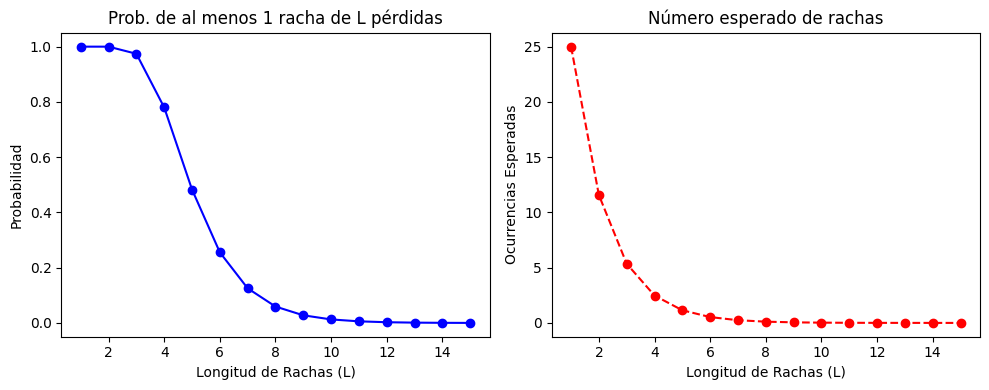


📊 Estadísticas Generales
- Expectancy: 4.27
- Profit Factor: 1.37
- Máximo Drawdown: -32.46%
- Máxima racha de ganancias: 6
- Máxima racha de pérdidas: 3



,0,1
entry_time,2025-06-09 09:35:35,2025-06-09 09:43:43
exit_time,2025-06-09 09:36:00,2025-06-09 09:43:46
asset,MNQM5@CME,MNQM5@CME
direction,Buy,Buy
entry_price,21770.75,21791.25
exit_price,21762.25,21784.5
position_size,4.0,4.0
PnL,-68.0,-54.5
PnL_net,-68.0,-54.5
commission,0.0,0.0


In [471]:
# =======================================
# Probabilidad de rachas con enfoque científico (DP)

import matplotlib.pyplot as plt
from functools import lru_cache

hist_df['win'] = hist_df['PnL'] > 0
emp_win_rate = hist_df['win'].mean()

def loss_streak_probability(win_rate, num_trades, streak_length):
    loss_rate = 1 - win_rate

    @lru_cache(maxsize=None)
    def prob_no_streak(n, current_streak):
        if current_streak >= streak_length:
            return 0.0
        if n == 0:
            return 1.0
        return (win_rate * prob_no_streak(n-1, 0) + 
                loss_rate * prob_no_streak(n-1, current_streak + 1))

    return 1 - prob_no_streak(num_trades, 0)

def analyze_streaks(win_rate, num_trades, max_streak=15):
    results = []
    for L in range(1, max_streak+1):
        prob = loss_streak_probability(win_rate, num_trades, L)
        results.append({
            'Streak Length': L,
            'Probability': prob,
            '1 in N Sequences': int(round(1/prob)) if prob > 0 else np.inf,
            'Expected Occurrences': (num_trades - L + 1) * ((1-win_rate)**L)
        })
    return pd.DataFrame(results)

def plot_streak_analysis(df):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(df['Streak Length'], df['Probability'], 'b-o')
    plt.xlabel('Longitud de Rachas (L)')
    plt.ylabel('Probabilidad')
    plt.title('Prob. de al menos 1 racha de L pérdidas')

    plt.subplot(1, 2, 2)
    plt.plot(df['Streak Length'], df['Expected Occurrences'], 'r--o')
    plt.xlabel('Longitud de Rachas (L)')
    plt.ylabel('Ocurrencias Esperadas')
    plt.title('Número esperado de rachas')
    plt.tight_layout()
    plt.show()

streak_analysis_df = analyze_streaks(win_rate=emp_win_rate, num_trades=len(hist_df))
plot_streak_analysis(streak_analysis_df)

wins = hist_df[hist_df['PnL'] > 0]['PnL']
losses = hist_df[hist_df['PnL'] < 0]['PnL']

expectancy = hist_df['PnL'].mean()
profit_factor = wins.sum() / abs(losses.sum()) if not losses.empty else np.nan

hist_df['equity_curve'] = 360 + hist_df['PnL'].cumsum()
hist_df['peak'] = hist_df['equity_curve'].cummax()
hist_df['drawdown'] = hist_df['equity_curve'] - hist_df['peak']
hist_df['drawdown_pct'] = hist_df['drawdown'] / hist_df['peak']
max_drawdown = hist_df['drawdown_pct'].min()

hist_df['result'] = hist_df['PnL'].apply(lambda x: 'win' if x > 0 else 'loss')
hist_df['streak_id'] = (hist_df['result'] != hist_df['result'].shift()).cumsum()
streaks = hist_df.groupby(['streak_id', 'result']).size().reset_index(name='length')
max_win_streak = streaks[streaks['result'] == 'win']['length'].max() if 'win' in streaks['result'].values else 0
max_loss_streak = streaks[streaks['result'] == 'loss']['length'].max() if 'loss' in streaks['result'].values else 0

print("""
📊 Estadísticas Generales
- Expectancy: {:.2f}
- Profit Factor: {:.2f}
- Máximo Drawdown: {:.2f}%
- Máxima racha de ganancias: {}
- Máxima racha de pérdidas: {}
""".format(expectancy, profit_factor, max_drawdown * 100, max_win_streak, max_loss_streak))

# =======================================
# Mostrar los primeros registros del DataFrame de trades
hist_df.head(2).T

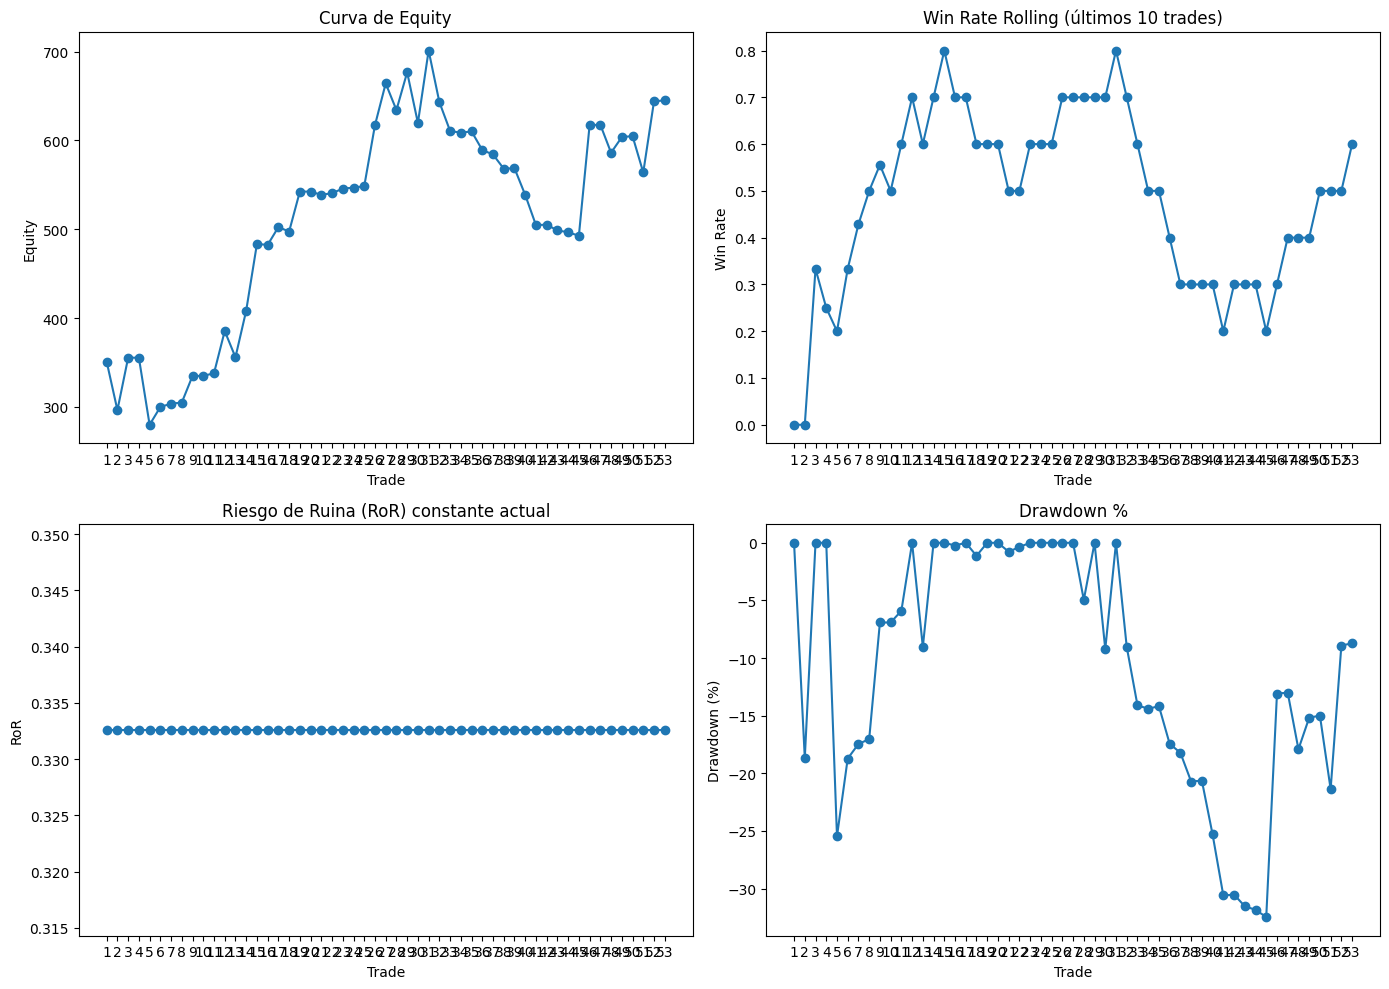

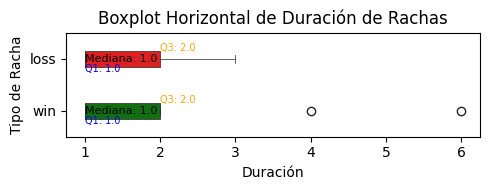


📈 Promedios de Rachas
- Duración promedio de rachas ganadoras: 1.87
- Duración promedio de rachas perdedoras: 1.67



In [472]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =======================================
log_scale = False  # prevención de error si aún no está definido

# Visualizaciones del rendimiento
# =======================================

hist_df['trade_n'] = range(1, len(hist_df)+1)
hist_df['cumulative_PnL'] = hist_df['PnL_net'].cumsum() if 'PnL_net' in hist_df.columns else hist_df['PnL'].cumsum()
hist_df['equity'] = INITIAL_CAPITAL + hist_df['cumulative_PnL']
hist_df['win'] = hist_df['PnL_net'] > 0 if 'PnL_net' in hist_df.columns else hist_df['PnL'] > 0
hist_df['rolling_win_rate'] = hist_df['win'].rolling(10, min_periods=1).mean()

# Calcular drawdown si no existe
if 'drawdown_pct' not in hist_df.columns:
    hist_df['peak'] = hist_df['equity'].cummax()
    hist_df['drawdown_pct'] = (hist_df['equity'] - hist_df['peak']) / hist_df['peak']

# Añadir columna de riesgo de ruina si no existe
if 'risk_of_ruin' in globals():
    hist_df['RoR'] = risk_of_ruin
else:
    hist_df['RoR'] = 0.0

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(hist_df['trade_n'], hist_df['equity'], marker='o')
plt.xticks(hist_df['trade_n'])
plt.title("Curva de Equity")
plt.xlabel("Trade")
plt.ylabel("Equity")
if log_scale:
    plt.yscale('log')

plt.subplot(2, 2, 2)
plt.plot(hist_df['trade_n'], hist_df['rolling_win_rate'], marker='o')
plt.xticks(hist_df['trade_n'])
plt.title("Win Rate Rolling (últimos 10 trades)")
plt.xlabel("Trade")
plt.ylabel("Win Rate")

plt.subplot(2, 2, 3)
plt.plot(hist_df['trade_n'], hist_df['RoR'], marker='o')
plt.xticks(hist_df['trade_n'])
plt.title("Riesgo de Ruina (RoR) constante actual")
plt.xlabel("Trade")
plt.ylabel("RoR")

plt.subplot(2, 2, 4)
plt.plot(hist_df['trade_n'], hist_df['drawdown_pct'] * 100, marker='o')
plt.xticks(hist_df['trade_n'])
plt.title("Drawdown %")
plt.xlabel("Trade")
plt.ylabel("Drawdown (%)")

plt.tight_layout()
plt.show()

# Boxplot de duración de rachas
fig, ax = plt.subplots(figsize=(5, 2))
sns.boxplot(data=streaks, y='result', x='length', hue='result', dodge=False,
            palette={"win": "green", "loss": "red"}, linewidth=0.5, width=0.3)

if ax.get_legend():
    ax.get_legend().remove()

ax.set_title("Boxplot Horizontal de Duración de Rachas")
ax.set_xlabel("Duración")
ax.set_ylabel("Tipo de Racha")

# Añadir etiquetas de estadísticos
for result_type in ['win', 'loss']:
    data = streaks[streaks['result'] == result_type]['length']
    if not data.empty:
        median = data.median()
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        ypos = 0 if result_type == 'win' else 1
        ax.text(median, ypos, f"Mediana: {median:.1f}", va='center', ha='left', fontsize=8, color='black')
        ax.text(q1, ypos + 0.2, f"Q1: {q1:.1f}", va='center', ha='left', fontsize=7, color='blue')
        ax.text(q3, ypos - 0.2, f"Q3: {q3:.1f}", va='center', ha='left', fontsize=7, color='orange')

plt.tight_layout()
plt.show()

# Promedios de duración de rachas
avg_win_streak = streaks[streaks['result'] == 'win']['length'].mean() if 'win' in streaks['result'].values else 0
avg_loss_streak = streaks[streaks['result'] == 'loss']['length'].mean() if 'loss' in streaks['result'].values else 0

print("""
📈 Promedios de Rachas
- Duración promedio de rachas ganadoras: {:.2f}
- Duración promedio de rachas perdedoras: {:.2f}
""".format(avg_win_streak, avg_loss_streak))

In [473]:
# =======================================
# Simulación de múltiples curvas de equity con sliders interactivos
# =======================================
# 📦 CELL 13: Simulación de múltiples curvas de equity
# ────────────────────────────────────────────

def simulate_equity_curves(win_rate, win_loss_ratio, risk_per_trade, n_trades, n_lines, initial_equity=INITIAL_CAPITAL):
    curves = []
    for _ in range(n_lines):
        equity = initial_equity
        path = [equity]
        for _ in range(n_trades):
            fluct = np.random.normal(1.0, 0.03)
            if np.random.rand() < win_rate / 100:
                equity += equity * (risk_per_trade / 100) * win_loss_ratio * fluct
            else:
                equity -= equity * (risk_per_trade / 100) * fluct
            path.append(equity)
        curves.append(path)
    return curves

try:
    default_win_rate = total_win_rate * 100
except NameError:
    default_win_rate = 55.0

def plot_equity_simulation(win_rate, win_loss_ratio, risk_per_trade, n_trades, n_lines, initial_equity_offset=0, log_scale=False):
    capital_actual = calcular_capital_actual(hist_df) + initial_equity_offset
    print(f"💼 Capital inicial simulado: ${capital_actual:.2f}  ← calculado como INITIAL_CAPITAL + PnL_net acumulado")
    curves = simulate_equity_curves(win_rate, win_loss_ratio, risk_per_trade, n_trades, n_lines, initial_equity=capital_actual)
    plt.figure(figsize=(10, 5))
    for path in curves:
        plt.plot(path, alpha=0.4, linewidth=1)
    avg_path = np.mean(curves, axis=0)
    plt.plot(avg_path, color='black', linewidth=2.5, label="Media", zorder=10)
    plt.title(f"Simulación de Curvas de Equity (Start: ${capital_actual:,.0f})")
    plt.xlabel("# Trade")
    plt.ylabel("Equity")
    if log_scale:
        plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

interact(
    plot_equity_simulation,
    win_rate=FloatSlider(value=default_win_rate, min=0, max=100, step=1, description='Win % (prob)'),
    win_loss_ratio=FloatSlider(value=profit_factor_global, min=0.1, max=5, step=0.01, description='Ratio Win/Loss'),
    risk_per_trade=FloatSlider(value=10, min=0, max=50, step=0.5, description='Risk % (por trade)'),
    n_trades=IntSlider(value=25, min=0, max=200, step=1, description='# Trades'),
    n_lines=IntSlider(value=5, min=1, max=200, step=1, description='Paths'),
    initial_equity_offset=IntSlider(value=0, min=0, max=5000, step=100, description='Start Adj.'),
    log_scale=Checkbox(value=False, description='Log Scale')
)

interactive(children=(FloatSlider(value=52.83018867924528, description='Win % (prob)', step=1.0), FloatSlider(…

<function __main__.plot_equity_simulation(win_rate, win_loss_ratio, risk_per_trade, n_trades, n_lines, initial_equity_offset=0, log_scale=False)>

**Propósito del parámetro `initial_equity_offset` del parámetro `Start Adj.`**

Este parámetro es un ajuste manual que se suma al capital base calculado desde tu histórico (calcular_capital_actual(hist_df)).

Ejemplo práctico:

Si tu equity actual (último trade) es 650 $ y pones:

* initial_equity_offset = 0 → la simulación parte de 650 $
* initial_equity_offset = 1000 → parte de 1650 $
* initial_equity_offset = -300 → parte de 350 $

⚙️ ¿Por qué usarlo?

* Para simular escenarios donde añades capital extra al sistema.
* Para probar la robustez del sistema en condiciones distintas al capital actual.
* Para modelar reinversiones o retiros del trader.

In [474]:
# =======================================
# Función de cálculo de probabilidad de racha
# =======================================

@lru_cache(maxsize=None)
def loss_streak_probability(win_rate, num_trades, streak_length):
    loss_rate = 1 - win_rate

    @lru_cache(maxsize=None)
    def prob_no_streak(n, current_streak):
        if current_streak >= streak_length:
            return 0.0
        if n == 0:
            return 1.0
        return (win_rate * prob_no_streak(n-1, 0) + 
                loss_rate * prob_no_streak(n-1, current_streak + 1))

    return 1 - prob_no_streak(num_trades, 0)

# =======================================
# Kelly mejorado con penalización por drawdown estimado
# =======================================

def calcular_kelly(P, R):
    if R == 0: return 0
    return P - (1 - P) / R

def penalizar_kelly(kelly, streak_prob):
    return max(0, kelly / (1 + streak_prob))

def simulador_kelly(win_rate_slider: float, ratio_slider: float, trades_slider: int, racha_slider: int):
    """Muestra Kelly clásico, Kelly penalizado y el $ a arriesgar según equity actual."""
    P = win_rate_slider / 100.0
    R = ratio_slider
    kelly_raw = calcular_kelly(P, R)
    prob_racha = loss_streak_probability(P, trades_slider, racha_slider)
    kelly_ajustado = penalizar_kelly(kelly_raw, prob_racha)

    # Equity actual (mismo cálculo que en simulación de curvas)
    capital_actual = calcular_capital_actual(hist_df)
    risk_dollars   = capital_actual * kelly_ajustado  # fracción de Kelly ajustado

    print("""
    📈 **Simulación Interactiva de Kelly Mejorado**
    - Win rate (P): {:.2f}%
    - Win/Loss ratio (R): {:.2f}
    - Trades evaluados: {}
    - Racha evaluada: ≥{}
    - Probabilidad de sufrir racha: {:.2f}%
    - Kelly % clásico: {:.2f}%
    - Kelly % ajustado (con penalización): {:.2f}%
    - 💵 Capital a arriesgar por trade: ${:,.2f}
    """.format(
        win_rate_slider, R, trades_slider, racha_slider,
        prob_racha * 100,
        kelly_raw * 100,
        kelly_ajustado * 100,
        risk_dollars))

interact(
    simulador_kelly,
    win_rate_slider=FloatSlider(value=default_win_rate, min=0, max=100, step=0.1, description='Win %'),
    ratio_slider=FloatSlider(value=profit_factor_global, min=0.1, max=10.0, step=0.01, description='Win/Loss R'),
    trades_slider=IntSlider(value=25, min=10, max=200, step=1, description='# Trades'),
    racha_slider=IntSlider(value=5, min=2, max=20, step=1, description='Racha ≥')
)

# =======================================
# Tabla de probabilidades de rachas según win rate y longitud (DINÁMICA)
# =======================================

def generate_streak_probability_table(trades=50, max_streak=11):
    percentages = list(range(5, 100, 5))
    table = []
    for win_rate in percentages:
        row = {'Win %': win_rate}
        for L in range(2, max_streak + 1):
            prob = loss_streak_probability(win_rate / 100, trades, L)
            row[f'≥{L}'] = f"{prob*100:.1f}%"
        table.append(row)
    return pd.DataFrame(table)

def plot_streak_probability_table(trades=50, max_streak=11):
    df = generate_streak_probability_table(trades=trades, max_streak=max_streak)
    df_numeric = df.set_index('Win %').apply(lambda col: col.str.rstrip('%').astype(float))
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.heatmap(
        df_numeric,
        cmap='RdYlGn_r', annot=df.set_index('Win %'), fmt='',
        cbar=False, linewidths=0.5, ax=ax
    )
    ax.set_title(f'Probabilidad de ver al menos (X) pérdidas consecutivas en {trades} trades')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=9, ha='right')
    plt.tight_layout()
    plt.show()

interact(
    plot_streak_probability_table,
    trades=IntSlider(value=50, min=10, max=200, step=10, description='# Trades'),
    max_streak=IntSlider(value=11, min=2, max=20, step=1, description='Racha ≥')
)

interactive(children=(FloatSlider(value=52.83018867924528, description='Win %'), FloatSlider(value=1.372274784…

interactive(children=(IntSlider(value=50, description='# Trades', max=200, min=10, step=10), IntSlider(value=1…

<function __main__.plot_streak_probability_table(trades=50, max_streak=11)>

In [475]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import lru_cache
from ipywidgets import interact, FloatSlider, IntSlider

# =======================================
# Función de cálculo de probabilidad de racha NEGATIVA
# =======================================
@lru_cache(maxsize=None)
def loss_streak_probability(win_rate, num_trades, streak_length):
    loss_rate = 1 - win_rate
    @lru_cache(maxsize=None)
    def prob_no_streak(n, current_streak):
        if current_streak >= streak_length: return 0.0
        if n == 0: return 1.0
        return win_rate * prob_no_streak(n-1, 0) + loss_rate * prob_no_streak(n-1, current_streak + 1)
    return 1 - prob_no_streak(num_trades, 0)

# =======================================
# Función de cálculo de probabilidad de racha POSITIVA
# =======================================
@lru_cache(maxsize=None)
def win_streak_probability(win_rate, num_trades, streak_length):
    loss_rate = 1 - win_rate
    @lru_cache(maxsize=None)
    def prob_no_streak(n, current_streak):
        if current_streak >= streak_length: return 0.0
        if n == 0: return 1.0
        return loss_rate * prob_no_streak(n-1, 0) + win_rate * prob_no_streak(n-1, current_streak + 1)
    return 1 - prob_no_streak(num_trades, 0)

# =======================================
# Kelly mejorado con penalización por drawdown estimado
# =======================================
def calcular_kelly(P, R):
    if R == 0: return 0
    return P - (1 - P) / R

def penalizar_kelly(kelly, streak_prob):
    return max(0, kelly / (1 + streak_prob))

def simulador_kelly(win_rate_slider, ratio_slider, trades_slider, racha_slider):
    P = win_rate_slider / 100
    R = ratio_slider
    kelly_raw = calcular_kelly(P, R)
    prob_racha_neg = loss_streak_probability(P, trades_slider, racha_slider)
    prob_racha_pos = win_streak_probability(P, trades_slider, racha_slider)
    kelly_ajustado = penalizar_kelly(kelly_raw, prob_racha_neg)

    print("""
📈 **Simulación Interactiva de Kelly Mejorado**
- Win rate (P): {:.2f}%
- Win/Loss ratio (R): {:.2f}
- Trades: {}
- Racha evaluada: ≥{}
- Probabilidad de racha NEGATIVA: {:.2f}%
- Probabilidad de racha POSITIVA: {:.2f}%
- Kelly % clásico: {:.2f}%
- Kelly % ajustado (con penalización negativa): {:.2f}%
    """.format(
        win_rate_slider, R, trades_slider, racha_slider,
        prob_racha_neg * 100, prob_racha_pos * 100,
        kelly_raw * 100, kelly_ajustado * 100
    ))

interact(
    simulador_kelly,
    win_rate_slider=FloatSlider(value=default_win_rate, min=0, max=100, step=0.1, description='Win %'),
    ratio_slider=FloatSlider(value=profit_factor_global, min=0.1, max=10.0, step=0.01, description='Win/Loss R'),
    trades_slider=IntSlider(value=25, min=10, max=200, step=1, description='# Trades'),
    racha_slider=IntSlider(value=5, min=2, max=20, step=1, description='Racha ≥')
)


# =======================================
# Tablas heatmap de rachas negativas y positivas
# =======================================
def generate_streak_probability_table(trades=50, max_streak=11, tipo="negativa"):
    percentages = list(range(5, 100, 5))
    table = []
    for win_rate in percentages:
        row = {'Win %': win_rate}
        for L in range(2, max_streak + 1):
            prob = (
                loss_streak_probability if tipo == "negativa"
                else win_streak_probability
            )(win_rate / 100, trades, L)
            row[f'≥{L}'] = f"{prob*100:.1f}%"
        table.append(row)
    return pd.DataFrame(table)

def plot_streak_probability_tables(trades=50, max_streak=11):
    cmap = 'RdYlGn'

    for tipo, title in [
        ("negativa", "pérdidas"),
        ("positiva", "ganancias")
    ]:
        df = generate_streak_probability_table(trades=trades, max_streak=max_streak, tipo=tipo)
        df_numeric = df.set_index('Win %').apply(lambda col: col.str.rstrip('%').astype(float))

        fig, ax = plt.subplots(figsize=(14, 6))
        sns.heatmap(
            df_numeric,
            cmap=cmap if tipo == "positiva" else cmap + '_r',  # misma escala, invertida según sentido
            annot=df.set_index('Win %'), fmt='',
            cbar=False, linewidths=0.5, ax=ax
        )

        ax.set_title(f'Probabilidad de ver al menos (X) {title} consecutivas en {trades} trades')
        plt.yticks(rotation=0)
        plt.xticks(rotation=45, fontsize=9, ha='right')
        plt.tight_layout()
        plt.show()


interact(
    plot_streak_probability_tables,
    trades=IntSlider(value=50, min=10, max=200, step=10, description='# Trades'),
    max_streak=IntSlider(value=11, min=2, max=20, step=1, description='Racha ≥')
)



interactive(children=(FloatSlider(value=52.83018867924528, description='Win %'), FloatSlider(value=1.372274784…

interactive(children=(IntSlider(value=50, description='# Trades', max=200, min=10, step=10), IntSlider(value=1…

<function __main__.plot_streak_probability_tables(trades=50, max_streak=11)>

In [498]:
# Visualización de ruina con % Kelly dinámico
# ────────────────────────────────────────
# ───────────────────────────────────────────────
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, Dropdown, Output
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calcular_kelly(P, R):
    if R == 0:
        return 0
    return max(P - (1 - P) / R, 0)

def calcular_ruina(capital_inicial, riesgo_pct, max_drawdown):
    capital = capital_inicial
    riesgo = riesgo_pct / 100
    n = 0
    capitales = [capital]
    while capital > capital_inicial * (1 - max_drawdown):
        capital *= (1 - riesgo)
        capitales.append(capital)
        n += 1
        if n > 100:
            break
    return n, capitales

def simular_random(P, R, riesgo_pct, n_trades, capital_inicial):
    capital = capital_inicial
    capitales = [capital]
    riesgo = riesgo_pct / 100
    for _ in range(n_trades):
        if np.random.rand() < P:
            capital += capital * riesgo * R
        else:
            capital -= capital * riesgo
        capitales.append(capital)
    return capitales

def generar_tabla_perdidas(capital_inicial, riesgo_pct, max_filas=10):
    valores = []
    capital = capital_inicial
    for i in range(1, max_filas + 1):
        capital -= capital * riesgo_pct
        valores.append((i, round(capital, 2)))
    return pd.DataFrame(valores, columns=["Trade #", "Capital tras pérdida"])

def simulador_kelly_dinamico(P, R, kelly_fraccion=1.0, capital_inicial=1000, max_drawdown=0.9, log_scale=False, simulacion='Determinista', n_trades_estocastico=100):
    kelly = calcular_kelly(P, R)
    fracciones = [kelly_fraccion, kelly_fraccion * 0.5, kelly_fraccion * 0.25]
    labels = [f"{kelly_fraccion*100:.0f}% Kelly", f"{kelly_fraccion*50:.0f}% Kelly", f"{kelly_fraccion*25:.0f}% Kelly"]

    output = Output()
    with output:
        riesgo_pct_actual = kelly * kelly_fraccion * 100
        capital_riesgo = capital_inicial * kelly * kelly_fraccion
        print(f"\nSimulación Interactiva de Kelly Mejorado")
        print(f"- Win rate (P): {P*100:.2f}%")
        print(f"- Win/Loss ratio (R): {R:.2f}")
        print(f"- Capital inicial: ${capital_inicial:,.0f}")
        print(f"- Kelly % dinámico base: {kelly*100:.2f}%")
        print(f"- Kelly % aplicado (slider): {kelly*kelly_fraccion*100:.2f}%")
        print(f"- 💵 Capital a arriesgar por trade: ${capital_riesgo:.2f}")
        print()

        print("\nTabla de capital tras cada pérdida:")
        tabla = generar_tabla_perdidas(capital_inicial, kelly * kelly_fraccion)
        print(tabla.to_string(index=False))

    display(output)

    plt.figure(figsize=(10, 6))

    for fraccion, label in zip(fracciones, labels):
        riesgo_pct = kelly * fraccion * 100
        if simulacion == 'Determinista':
            r, caps = calcular_ruina(capital_inicial, riesgo_pct, max_drawdown / 100)
            plt.plot(range(r+1), caps, label=f"{label} ({r} trades)", linewidth=2)
        else:
            caps = simular_random(P, R, riesgo_pct, n_trades_estocastico, capital_inicial)
            plt.plot(caps, label=label, linewidth=2)

    plt.axhline(y=capital_inicial * (1 - max_drawdown / 100), color='red', linestyle='--', label='Límite ruina')
    plt.title("Simulación de Ruina según % Kelly aplicado")
    plt.xlabel("# Trades")
    plt.ylabel("Capital restante")
    if log_scale:
        plt.yscale("log")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

interact(
    simulador_kelly_dinamico,
    P=FloatSlider(value=default_win_rate / 100, min=0, max=1.0, step=0.001, description='Win %'),
    R=FloatSlider(value=profit_factor_global, min=0.1, max=10.0, step=0.01, description='Win/Loss R'),
    kelly_fraccion=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.05, description='% Kelly'),
    capital_inicial=IntSlider(value=int(capital_actual), min=100, max=10000, step=1, description='Capital $'),
    max_drawdown=FloatSlider(value=50, min=0.1, max=100, step=0.01, description='Drawdown %'),
    log_scale=Checkbox(value=False, description='Log scale'),
    simulacion=Dropdown(options=['Determinista', 'Estocástica'], value='Determinista', description='Modo'),
    n_trades_estocastico=IntSlider(value=100, min=10, max=200, step=10, description='# Trades Est.')
)



interactive(children=(FloatSlider(value=0.5283018867924528, description='Win %', max=1.0, step=0.001), FloatSl…

<function __main__.simulador_kelly_dinamico(P, R, kelly_fraccion=1.0, capital_inicial=1000, max_drawdown=0.9, log_scale=False, simulacion='Determinista', n_trades_estocastico=100)>

Este gráfico te ayuda a entender cuánto tiempo puedes sobrevivir operando con tu dinero, si arriesgas cierto porcentaje en cada operación. El método de Kelly te dice qué porcentaje de tu dinero deberías arriesgar en cada trade** para ganar lo máximo posible a largo plazo, sin arruinarte.

- Si arriesgas demasiado, puedes perder todo muy rápido.
- Si arriesgas muy poco, ganas tan lento que no vale la pena.


---


Vamos paso a paso con los números:

![](img/05.png)

* Capital inicial: 645 \$
* Drawdown permitido: 50 %. Por lo tanto, el límite de ruina es 645 × 0.5 = 322.5 \$
* Kelly aplicado: 9.17 %. Esto significa que arriesgas 645 × 0.0917 ≈ 59.17 \$ en el primer trade

Ahora vamos a simular qué pasa si pierdes varias operaciones seguidas, cada una restando el porcentaje correspondiente al capital restante. Es una caída exponencial, no lineal.

1. Capital tras 1 pérdida: 645 - (645 × 0.0917) = 585.83
2. Capital tras 2 pérdidas: 585.83 - (585.83 × 0.0917) = 532.10
3. Capital tras 3 pérdidas: 532.10 - (532.10 × 0.0917) = 483.47
4. Capital tras 4 pérdidas: 483.47 - (483.47 × 0.0917) = 439.18
5. Capital tras 5 pérdidas: 439.18 - (439.18 × 0.0917) = 398.61
6. Capital tras 6 pérdidas: 398.61 - (398.61 × 0.0917) = 361.24
7. Capital tras 7 pérdidas: 361.24 - (361.24 × 0.0917) = 326.46
8. Capital tras 8 pérdidas: 326.46 - (326.46 × 0.0917) = 294.49

Después de 7 pérdidas seguidas estás casi tocando el límite de ruina (322.5 \$). Después de la octava pérdida, ya caes por debajo del umbral.

Por eso el gráfico muestra que alcanzas el límite de ruina en 7 trades. No estás restando 59.17 \$ cada vez, sino un porcentaje del capital restante. Por eso necesitas más de 5 pérdidas consecutivas para quebrar.

**¿Cuál es la diferencia entre "Determinista" y "Estocástica"?**

`Modo Determinista`

- En este modo, se asume que todas las operaciones son pérdidas consecutivas.
- Se utiliza para calcular cuántas operaciones seguidas malas puedes soportar antes de caer por debajo del límite de ruina.
- Es útil para evaluar el peor escenario posible.
- Por ejemplo, si arriesgas el 10 por ciento del capital en cada trade, y pierdes 7 veces seguidas, tu capital disminuirá un 10 por ciento cada vez hasta cruzar el límite.
- La simulación determinista asume solo pérdidas continuas, y aplica la fórmula:  $\text{Capital nuevo = Capital anterior × (1 - riesgo por trade)}$ en cada paso. Es decir, no estás perdiendo $100 cada vez, sino un porcentaje del capital restante, que cada vez es menor.
- Aunque empieces arriesgando, por ejemplo, $100, en el segundo trade estarás arriesgando menos de $100 porque tu capital ha bajado. Así, el capital no baja linealmente, sino exponencialmente más lento.
- Por eso, aunque arriesgues mucho al principio, el número de trades para caer por debajo del umbral de ruina no es estrictamente proporcional, sino un logaritmo del capital restante dividido entre el riesgo porcentual.

`Modo Estocástico`

- En este modo, las operaciones se simulan aleatoriamente.
- Se respeta la probabilidad de ganar o perder según el win rate.
- Las pérdidas y ganancias se distribuyen de forma aleatoria como ocurre en la vida real.
- Este modo da una visión más realista de cómo evolucionaría tu capital en un entorno de mercado normal.

**Cuándo usar cada uno**

- Usa el modo determinista si quieres saber cuántos errores consecutivos puedes cometer sin irte a la ruina.
- Usa el modo estocástico si quieres ver cómo se comporta tu capital con una mezcla de trades ganadores y perdedores, imitando el azar del trading real.

--- 




